# Setup, matplotlib inline, automatically reload libraries on every evaluation

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
from creon.loadcreon import LoadCreon, save_search, load_search
from creon.semisuperhelper import SemiSupervisedHelper
from creon.creonsklearn.pnuwrapper import PNUWrapper
from creon.creonsklearn.jeffsearchcv import JeffRandomSearchCV, extract_score_grid
from creon.creonsklearn.nestedcross import NestedCV
from creon.creonsklearn.frankenscorer import FrankenScorer, extract_scores_from_nested

In [2]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [4]:
path = "C:\Data\\010317\membership14_final_0103.txt"
lc = LoadCreon(path)

In [133]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.base import clone
from sklearn.metrics import f1_score, fbeta_score, recall_score, precision_score

In [166]:
#create train, test(for xgboost), platt (for calibration), and test_end (for metrics estimation!)!
X_train, X_test_end, y_train, y_test_end = train_test_split(lc.X, lc.y, test_size=0.2, random_state=771, stratify=lc.y)
X_train, X_platt, y_train, y_platt = train_test_split(X_train, y_train, test_size=0.2, random_state=77, stratify=y_train)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=82, stratify=y_train)

In [167]:
len(y_train), len(y_platt), len(y_test_end), len(y_test)

(225635, 70512, 88140, 56409)

# SET UP XGBOOST FIRST TRY! Let's do -1 and 1 outputs and linear, rmse

In [168]:
y_train_xg = y_train.copy()
y_train_xg[y_train_xg==0] = -1
y_train_xg.value_counts()

-1    224566
 1      1069
dtype: int64

In [169]:
dtrain = xgb.DMatrix(X_train.values, label=y_train_xg.values)

In [170]:
y_test_xg = y_test.copy()
y_test_xg[y_test_xg==0] = -1
y_test_xg.value_counts()

-1    56142
 1      267
dtype: int64

In [171]:
dtest = xgb.DMatrix(X_test.values, label=y_test_xg.values)

In [172]:
param = {'max_depth':6, 'eta':0.3}

In [173]:
watchlist = [(dtest,'eval'),(dtrain,'train')]

In [178]:
num_round = 18

In [179]:
bst = xgb.train(param, dtrain, num_round, watchlist)

[0]	eval-rmse:1.05199	train-rmse:1.05175
[1]	eval-rmse:0.742205	train-rmse:0.741691
[2]	eval-rmse:0.527808	train-rmse:0.526626
[3]	eval-rmse:0.380908	train-rmse:0.378822
[4]	eval-rmse:0.282244	train-rmse:0.278671
[5]	eval-rmse:0.218207	train-rmse:0.21277
[6]	eval-rmse:0.178608	train-rmse:0.171433
[7]	eval-rmse:0.155684	train-rmse:0.146671
[8]	eval-rmse:0.143085	train-rmse:0.132735
[9]	eval-rmse:0.136303	train-rmse:0.124912
[10]	eval-rmse:0.133058	train-rmse:0.120691
[11]	eval-rmse:0.131353	train-rmse:0.118425
[12]	eval-rmse:0.130603	train-rmse:0.116638
[13]	eval-rmse:0.130372	train-rmse:0.115419
[14]	eval-rmse:0.130286	train-rmse:0.114573
[15]	eval-rmse:0.130298	train-rmse:0.114384
[16]	eval-rmse:0.13023	train-rmse:0.113439
[17]	eval-rmse:0.130065	train-rmse:0.11308


In [180]:
y_platt_xg = y_platt.copy()
y_platt_xg[y_platt_xg==0]=-1
dplatt = xgb.DMatrix(X_platt.values, label=y_platt_xg.values)

In [210]:
y_test_end_xg = y_test_end.copy()
y_test_end_xg[y_test_end_xg==0]=-1
dtest_end = xgb.DMatrix(X_test_end.values, label=y_test_end_xg.values)

In [181]:
preds_platt = bst.predict(dplatt)
labels = dplatt.get_label()

In [211]:
preds_test_end = bst.predict(dtest_end)

In [196]:
len(preds_platt), len(y_platt)

(70512, 70512)

In [182]:
len(preds_platt[preds_platt >= -0.9562]) / len(preds_platt)

0.04409178579532562

In [183]:
y_pred = preds_platt.copy()
y_pred[y_pred >= -0.9562] = 1
y_pred[y_pred < -0.9562] = 0

In [184]:
pd.Series(y_pred).value_counts()

0.0    67403
1.0     3109
dtype: int64

In [185]:
import creonmetrics as cm

In [186]:
cm.pr_one_unlabeled(y_platt.values, y_pred)

0.040625089278061882

In [187]:
cm.pu_score(y_platt.values, y_pred)

11.808193536982712

In [188]:
cm.assumed_metric(y_platt.values, y_pred, fbeta_score, beta=10)

0.66671231751075077

In [189]:
cm.labeled_metric(y_platt.values, y_pred, f1_score)

0.80467445742904842

In [206]:
def calc_threshold(y_true, y_calced, thresholds):
    scores = []
    for t in thresholds:
        y_pred = y_calced.copy()
        y_pred[y_pred >= t] = 1
        y_pred[y_pred < t] = 0
        s = {'beta10':cm.assumed_metric(y_true.values, y_pred, fbeta_score, beta=10),
            'pu_score':cm.pu_score(y_true.values, y_pred),
            'f1_score':cm.labeled_metric(y_true.values, y_pred, f1_score),
            'recall':cm.labeled_metric(y_true.values, y_pred, recall_score),
            'precision':cm.labeled_metric(y_true.values, y_pred, precision_score),
            'pr_one':cm.pr_one_unlabeled(y_true.values, y_pred)}
        scores.append(s)
    return list(zip(thresholds, scores))

In [202]:
calc_threshold(y_platt, preds_platt, np.linspace(start=-.980, stop=-0.999, num=30))

[(-0.97999999999999998,
  {'beta10': 0.67089862059729477, 'pr_one': 0.052281233037168244}),
 (-0.98065517241379307,
  {'beta10': 0.66971471351033385, 'pr_one': 0.053224009370625373}),
 (-0.98131034482758617,
  {'beta10': 0.66801792191167053, 'pr_one': 0.054581035911207609}),
 (-0.98196551724137926,
  {'beta10': 0.66714609135703817, 'pr_one': 0.055280975916350027}),
 (-0.98262068965517235,
  {'beta10': 0.67193570706264305, 'pr_one': 0.055723795103276859}),
 (-0.98327586206896556,
  {'beta10': 0.67431839340337818, 'pr_one': 0.055938062451789845}),
 (-0.98393103448275865,
  {'beta10': 0.67392402371268312, 'pr_one': 0.056252321229608888}),
 (-0.98458620689655174,
  {'beta10': 0.67363749900353409, 'pr_one': 0.056480873068022741}),
 (-0.98524137931034483,
  {'beta10': 0.67279723991507423, 'pr_one': 0.057152244093363426}),
 (-0.98589655172413793,
  {'beta10': 0.67700826621449761, 'pr_one': 0.058037882467217097}),
 (-0.98655172413793102,
  {'beta10': 0.68342452356408434, 'pr_one': 0.0592520641

In [207]:
calc_threshold(y_platt, preds_platt, [-0.9872])

[(-0.9872,
  {'beta10': 0.68433957289744263,
   'f1_score': 0.82903225806451619,
   'pr_one': 0.060623375139273773,
   'precision': 0.89860139860139865,
   'pu_score': 9.2159082873235185,
   'recall': 0.76946107784431139})]

In [214]:
preds_platt_s = pd.Series(preds_platt) + 0.9872

## Platt scale results to get brier scores

In [209]:
from sklearn.linear_model import LogisticRegression

In [216]:
preds_test_end + 0.9872

array([-0.00948095, -0.00948095, -0.00905335, ..., -0.00948095,
       -0.00948095, -0.0053519 ], dtype=float32)

In [217]:
lr = LogisticRegression()
lr.fit(preds_platt_s.reshape((-1, 1)), y_platt.values)
p_calibrated = lr.predict_proba((preds_test_end + 0.9872).reshape((-1, 1)))[:,1]

c:\Users\jeffrey.gomberg\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


In [219]:
calc_threshold(y_test_end, p_calibrated, [0])

[(0,
  {'beta10': 0.324903801754656,
   'f1_score': 0.79543292102759267,
   'pr_one': 1.0,
   'precision': 0.66034755134281198,
   'pu_score': 1.0,
   'recall': 1.0})]

# May want to try probability below using binary:logistic

In [114]:
param_bin = {'max_depth':6, 'eta':0.3, 'objective':'binary:logistic'}

In [110]:
y_train_xg_bin = y_train.copy()
y_train_xg_bin[y_train_xg==-1] = 0
y_train_xg_bin.value_counts()

0    350886
1      1670
dtype: int64

In [112]:
y_test_xg_bin = y_test.copy()
y_test_xg_bin[y_test_xg_bin==-1] = 0
y_test_xg_bin.value_counts()

0    87722
1      418
dtype: int64

In [113]:
dtrain_bin = xgb.DMatrix(X_train.values, label=y_train_xg_bin.values)
dtest_bin = xgb.DMatrix(X_test.values, label=y_test_xg_bin.values)
watchlist_bin = [(dtest_bin,'eval'),(dtrain_bin,'train')]
num_round_bin = 10

In [115]:
bst_bin = xgb.train(param_bin, dtrain_bin, num_round_bin, watchlist_bin)

[0]	eval-error:0.004879	train-error:0.004524
[1]	eval-error:0.004776	train-error:0.004527
[2]	eval-error:0.004788	train-error:0.00451
[3]	eval-error:0.004776	train-error:0.004547
[4]	eval-error:0.004731	train-error:0.004484
[5]	eval-error:0.004708	train-error:0.004462
[6]	eval-error:0.00472	train-error:0.004456
[7]	eval-error:0.004708	train-error:0.004413
[8]	eval-error:0.004742	train-error:0.004385
[9]	eval-error:0.004708	train-error:0.004354
[10]	eval-error:0.004708	train-error:0.004343
[11]	eval-error:0.004708	train-error:0.004328
[12]	eval-error:0.004708	train-error:0.004294
[13]	eval-error:0.004708	train-error:0.004292
[14]	eval-error:0.004742	train-error:0.004263
[15]	eval-error:0.004754	train-error:0.004212
[16]	eval-error:0.004742	train-error:0.00415
[17]	eval-error:0.004776	train-error:0.004099
[18]	eval-error:0.004788	train-error:0.00405
[19]	eval-error:0.004765	train-error:0.003997
[20]	eval-error:0.004754	train-error:0.00398
[21]	eval-error:0.004754	train-error:0.003934
[22

In [116]:
preds_bin = bst_bin.predict(dtest_bin)
labels_bin = dtest_bin.get_label()

In [117]:
preds_bin

array([ 0.00075189,  0.00044098,  0.001111  , ...,  0.00031355,
        0.00068524,  0.00554007], dtype=float32)

In [125]:
len(preds_bin[preds_bin >= 0.3]) / len(preds_bin)

0.002087587928295893

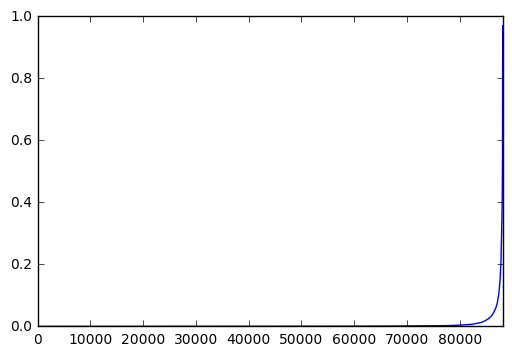

In [131]:
pd.Series(preds_bin).sort_values().reset_index(drop=True).plot()